<a href="https://colab.research.google.com/github/wilberquito/ds-thesis/blob/main/Code/NN/MelanomaClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melanoma classifier with Pytorch


In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print(f"In colab: {IN_COLAB}")

In colab: True


In [14]:
import requests
from pathlib import Path
import pandas as pd
import seaborn as sns

In [3]:
def pull_kaggle_auth():
  kaggle_json_url = 'https://raw.githubusercontent.com/wilberquito/ds-thesis/main/Code/NN/kaggle.json'
  kaggle_json = '/root/.kaggle/kaggle.json'
  
  if Path(kaggle_json).exists():
    print('Kaggle auth already configured')
  else:
    Path('/root/.kaggle').mkdir(parents=True, exist_ok=True)
    with open(kaggle_json, 'wb') as f:
      print('Configuring kaggle auth...')
      request = requests.get(kaggle_json_url)
      f.write(request.content)
      print(request.content)
      !chmod 600 ~/.kaggle/kaggle.json

pull_kaggle_auth()

Configuring kaggle auth...
b'{"username":"wilberquito","key":"a1cef5be103afee00ae036396afa6cbe"}'


In [13]:
def pull_scripts():
  if not IN_COLAB:
    print('No script will be downloaded as you are working in a local machine...')
    return
    
  scripts = {
      Path('dataset.py'): 'https://raw.githubusercontent.com/wilberquito/ds-thesis/main/Code/NN/dataset.py',
      Path('predict_single_fold.py'): 'https://raw.githubusercontent.com/wilberquito/ds-thesis/main/Code/NN/predict_single_fold.py'
  }

  for script, url in scripts.items():
    print(f'Downloading {script} script...')
    with open(script, 'wb') as f:
      req = requests.get(url)
      f.write(req.content)

pull_scripts()

In [5]:
def pull_data():
  downloader_script_url = 'https://raw.githubusercontent.com/wilberquito/ds-thesis/main/Code/NN/downloader.sh'
  downloader_script = 'downloader.sh'

  if not Path(downloader_script).exists():
    print('Downloading script downloader...')
    with open(downloader_script, 'wb') as f:
      request = requests.get(downloader_script_url)
      f.write(request.content)
    print('Downloading data using the downloader script...')
    !sh downloader.sh

pull_data() 

100% 1.37G/1.38G [00:12<00:00, 95.6MB/s]
100% 1.38G/1.38G [00:12<00:00, 115MB/s] 
100% 2.62G/2.63G [00:28<00:00, 127MB/s]
100% 2.63G/2.63G [00:28<00:00, 100MB/s]
 99% 2.73G/2.74G [00:23<00:00, 89.5MB/s]
100% 2.74G/2.74G [00:23<00:00, 123MB/s] 
100% 5.32G/5.32G [00:38<00:00, 101MB/s] 
100% 5.32G/5.32G [00:38<00:00, 148MB/s]
100% 4.72G/4.72G [00:33<00:00, 197MB/s]
100% 4.72G/4.72G [00:33<00:00, 153MB/s]
100% 8.83G/8.85G [01:08<00:00, 134MB/s]
100% 8.85G/8.85G [01:08<00:00, 139MB/s]


In [6]:
def pull_weights():

  if (Path('weights').exists()):
    print('models already downloaded')
  else:
    Path('weights').mkdir(parents=True, exist_ok=True)
    m1_url = 'https://github.com/wilberquito/ds-thesis/raw/vicorob_model/weights/8c_b3_768_512_18ep_best_20_fold0.pth'
    m2_url = 'https://github.com/wilberquito/ds-thesis/raw/vicorob_model/weights/8c_b3_768_512_18ep_best_fold0.pth'
    m3_url = 'https://github.com/wilberquito/ds-thesis/raw/vicorob_model/weights/8c_b3_768_512_18ep_final_fold0.pth'

    for url in [m1_url, m2_url, m3_url]:
      filename = url.split('/')[-1]
      save_path = Path('weights') / Path(filename)
      with open(save_path, 'wb') as f:
        print(f'Downloading {url}...')
        req = requests.get(url)
        f.write(req.content)

pull_weights()

## Exploratory data analysis

In [7]:
path = Path(f'./data/jpeg-melanoma-{512}x{512}/train.csv')
df = pd.read_csv(path)
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
 8   tfrecord                       33126 non-null  int64  
 9   width                          33126 non-null  int64  
 10  height                         33126 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 2.8+ MB


In [9]:
df.describe()

,age_approx,target,tfrecord,width,height
count,33058.000000,33126.000000,33126.000000,33126.000000,33126.000000
mean,48.870016,0.017630,6.894826,4039.630381,2678.758256
std,14.380360,0.131603,4.390486,2109.145590,1437.617626
min,0.000000,0.000000,-1.000000,640.000000,480.000000
25%,40.000000,0.000000,3.000000,1872.000000,1053.000000
50%,50.000000,0.000000,7.000000,5184.000000,3456.000000
75%,60.000000,0.000000,11.000000,6000.000000,4000.000000
max,90.000000,1.000000,14.000000,6000.000000,6000.000000


### Diagnosis

Here I notice that the are a lot of `unknown` diagnosis. 

There are also few examples of `solar lentigo`, `cafe-au-lait macule` and `atypical melanocytic proliferation`. 

In [10]:
diagnosis_freq = df['diagnosis'].value_counts()
diagnosis_freq

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

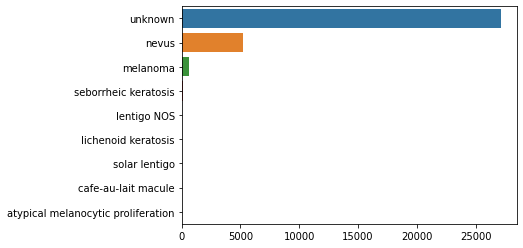

In [15]:
_ = sns.barplot(x=diagnosis_freq.values, y=diagnosis_freq.index)

### TfRecord

`tfrecord` can be labeled as `-1`, which means that they don't know exactly which values is. This samples may be droped.

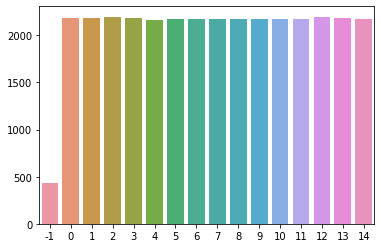

In [16]:
tfrecord_freq = df['tfrecord'].value_counts()
_ = sns.barplot(y=tfrecord_freq.values, x=tfrecord_freq.index)

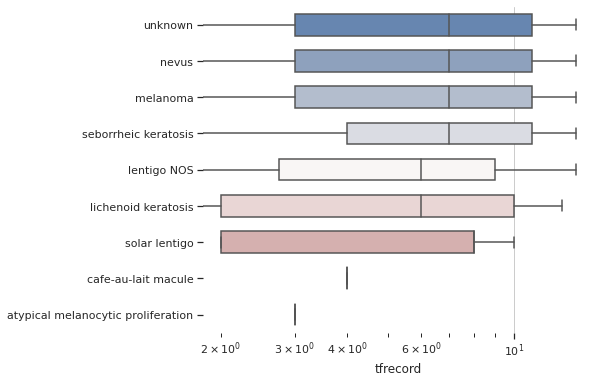

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="tfrecord", y="diagnosis", data=df,
            whis=[0, 100], width=.6, palette="vlag")

# # Add in points to show each observation
# sns.stripplot(x="distance", y="method", data=df,
#               size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)